The least populated class in y has only 3 members, which is less than n_splits=4.


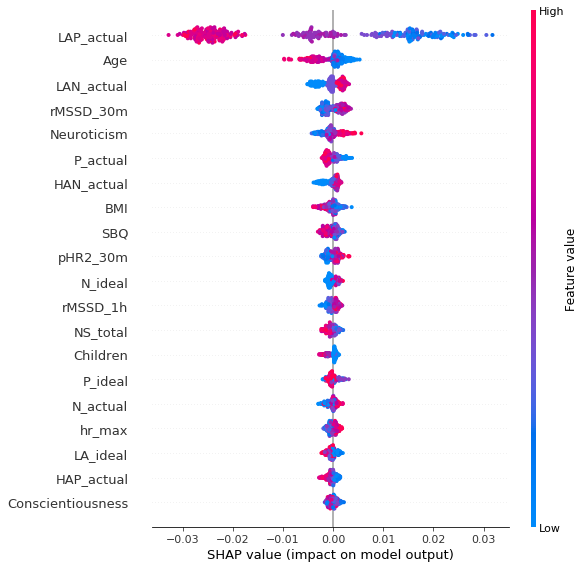

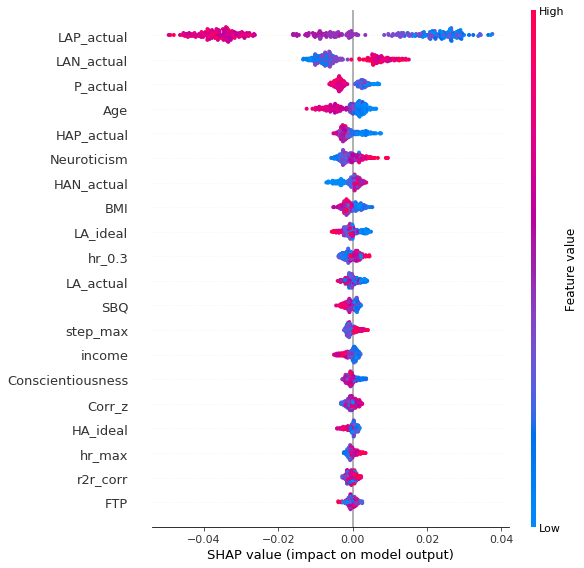

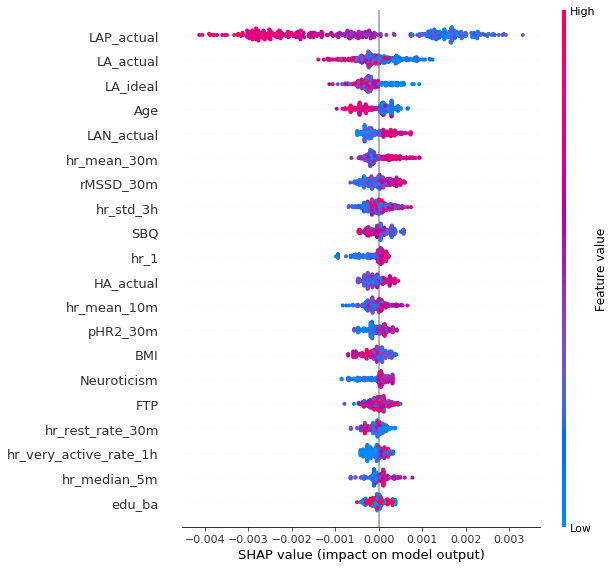

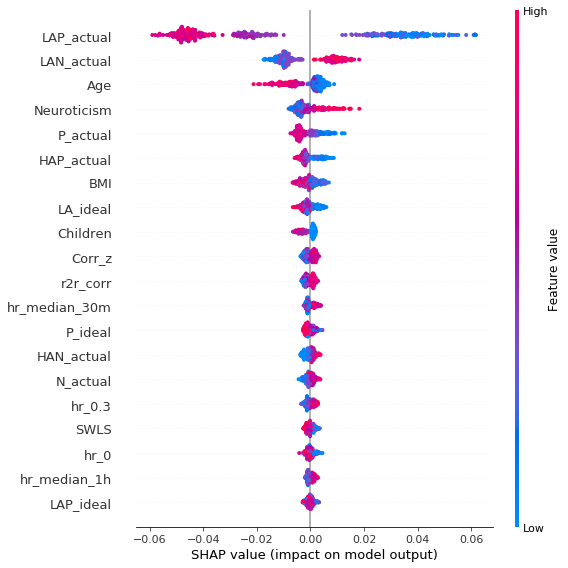

In [6]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import catboost
from evaluation_tools import eval_class, eval_reg, get_feature_imp_plot, convert_reg_to_class, catboost_feature_importance
from sklearn.model_selection import GroupKFold, StratifiedKFold
import pdb

# File for model
# result = pd.DataFrame(columns=['model_id','problem_type', 'data_type', 'data_sample', 'user_type', 'param_index', 'accuracy', 'recall', 'precision', 'specificity', 'npv', 'f1', 'RMSE', 'r2'])
# result.to_csv('model_evaluation.csv', index=False)

fitbit_features = ['step_max', 'step_min', 'step_median', 'steps_max_3h',
    'steps_min_3h', 'steps_mean_3h', 'steps_var_3h', 'steps_median_3h',
    'move_rate_3h', 'active_rate_3h', 'very_active_rate_3h',
    'running_rate_3h', 'steps_max_1h', 'steps_min_1h', 'steps_mean_1h',
    'steps_var_1h', 'steps_median_1h', 'move_rate_1h',
    'active_rate_1h', 'very_active_rate_1h', 'running_rate_1h',
    'steps_max_30m', 'steps_min_30m', 'steps_mean_30m',
    'steps_var_30m', 'steps_median_30m', 'move_rate_30m',
    'active_rate_30m', 'very_active_rate_30m', 'running_rate_30m',
    'steps_max_10m', 'steps_min_10m', 'steps_mean_10m',
    'steps_var_10m', 'steps_median_10m', 'move_rate_10m',
    'active_rate_10m', 'very_active_rate_10m', 'running_rate_10m',
    'steps_max_5m', 'steps_min_5m', 'steps_mean_5m', 'steps_var_5m',
    'steps_median_5m', 'move_rate_5m', 'active_rate_5m',
    'very_active_rate_5m', 'running_rate_5m', 'hr_max', 'hr_min',
    'hr_med', 'hr_0', 'hr_0.3', 'hr_0.5', 'hr_0.8', 'hr_1', 'SDNN_3h',
    'pHR2_3h', 'rMSSD_3h', 'low_hr_3h', 'high_hr_3h', 'l_h_3h',
    'CR_3h', 'hr_mean_3h', 'hr_var_3h', 'hr_std_3h', 'hr_median_3h',
    'hr_rest_rate_3h', 'hr_moderate_rate_3h', 'hr_very_active_rate_3h',
    'SDNN_1h', 'pHR2_1h', 'rMSSD_1h', 'low_hr_1h', 'high_hr_1h',
    'l_h_1h', 'CR_1h', 'hr_mean_1h', 'hr_var_1h', 'hr_std_1h',
    'hr_median_1h', 'hr_rest_rate_1h', 'hr_moderate_rate_1h',
    'hr_very_active_rate_1h', 'SDNN_30m', 'pHR2_30m', 'rMSSD_30m',
    'low_hr_30m', 'high_hr_30m', 'l_h_30m', 'CR_30m', 'hr_mean_30m',
    'hr_var_30m', 'hr_std_30m', 'hr_median_30m', 'hr_rest_rate_30m',
    'hr_moderate_rate_30m', 'hr_very_active_rate_30m', 'SDNN_10m',
    'pHR2_10m', 'rMSSD_10m', 'low_hr_10m', 'high_hr_10m', 'l_h_10m',
    'CR_10m', 'hr_mean_10m', 'hr_var_10m', 'hr_std_10m',
    'hr_median_10m', 'hr_rest_rate_10m', 'hr_moderate_rate_10m',
    'hr_very_active_rate_10m', 'SDNN_5m', 'pHR2_5m', 'rMSSD_5m',
    'low_hr_5m', 'high_hr_5m', 'l_h_5m', 'CR_5m', 'hr_mean_5m',
    'hr_var_5m', 'hr_std_5m', 'hr_median_5m', 'hr_rest_rate_5m',
    'hr_moderate_rate_5m', 'hr_very_active_rate_5m']

all_features = fitbit_features + ['SBQ', 'FTP', 'SWLS', 'Neuroticism', 
    'Extraversion', 'Conscientiousness', 'NS_total', 'BIS_total', 
    'BIS.5', 'BAS_D', 'BAS_FS', 'BAS_RR', 'HAP_actual', 'P_actual', 
    'LAP_actual', 'LA_actual', 'LAN_actual', 'N_actual', 'HAN_actual', 
    'HA_actual', 'HAP_ideal', 'P_ideal', 'LAP_ideal', 'LA_ideal', 
    'LAN_ideal', 'N_ideal', 'HAN_ideal', 'HA_ideal', 'Children', 'Age', 
    'BMI', 'survey_hour', 'r2r_corr', 'Corr_z', 'edu_hs', 
    'edu_ba', 'edu_ma', 'edu_phd', 'is_married', 'is_divorced', 
    'is_single', 'is_widowed', 'is_with_partner', 'income']


# Existing Users
X_stratified_val = pd.read_csv('../data/processed/cur_user/X_val_stratify.csv')
y_stratified_val = pd.read_csv('../data/processed/cur_user/y_val_stratify.csv')
X_stratified_test = pd.read_csv('../data/processed/cur_user/X_test_stratify.csv')
y_stratified_test = pd.read_csv('../data/processed/cur_user/y_test_stratify.csv')
X_stratified_train = pd.read_csv('../data/processed/cur_user/X_train_stratify.csv')
y_stratified_train = pd.read_csv('../data/processed/cur_user/y_train_stratify.csv')
X_stratified_up_train = pd.read_csv('../data/processed/cur_user/X_train_stratify_up.csv')
y_stratified_up_train = pd.read_csv('../data/processed/cur_user/y_train_stratify_up.csv')


# New Users
X_group_val = pd.read_csv('../data/processed/new_user/X_val_group.csv')
y_group_val = pd.read_csv('../data/processed/new_user/y_val_group.csv')
X_group_test = pd.read_csv('../data/processed/new_user/X_test_group.csv')
y_group_test = pd.read_csv('../data/processed/new_user/y_test_group.csv')
X_group_train = pd.read_csv('../data/processed/new_user/X_train_group.csv')
y_group_train = pd.read_csv('../data/processed/new_user/y_train_group.csv')
X_group_up_train = pd.read_csv('../data/processed/new_user/X_train_group_up.csv')
y_group_up_train = pd.read_csv('../data/processed/new_user/y_train_group_up.csv')


param1 = {
    'verbose': 10,
    'random_seed': 24,
    'depth':10, 
    'learning_rate':0.001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}
params = [param1]


def upsample_data(X, y):
    # concatenate our training data back together
    data_to_sample = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    unhappy = data_to_sample[data_to_sample['valence']==1]
    happy = data_to_sample[data_to_sample['valence']==0]

    # upsample minority
    unhappy_upsampled = resample(unhappy,
                        replace=True, # sample with replacement
                        n_samples=len(happy), # match number in majority class
                        random_state=27) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([happy, unhappy_upsampled])

    # Split train and test
    y_upsample = upsampled['valence']
    X_upsample = upsampled.drop('valence', axis=1)

    return X_upsample, y_upsample


def data_process(data_sample, X_train, y_train, param):
    if data_sample == 'up':
        X_train, y_train = upsample_data(X_train, y_train)
    elif data_sample == 'weight':
        class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
        param['class_weights'] = list(class_weights)
    elif data_sample == 'smote':
        sm = SMOTE(random_state=27, k_neighbors = 10, sampling_strategy=1.0)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    elif data_sample == 'no':
        pass
    else:   
        raise ValueError('Invalid value for <data_sample>')
    return X_train, y_train, param


def main(problem_type, data_type, data_sample, user_type, param_index):
    param = params[param_index] # Hyper params
    results = []

    if user_type == 'new':
        X_train = X_group_train
        y_train = y_group_train
        X_test = X_group_test
        y_test = y_group_test
        X_val = X_group_val
        y_val = y_group_val
    elif user_type == 'cur':
        X_train = X_stratified_train
        y_train = y_stratified_train
        X_test = X_stratified_test
        y_test = y_stratified_test
        X_val = X_stratified_val
        y_val = y_stratified_val
    else:
        raise ValueError('Invalid value for <user_type>')

    if data_type == 'fitbit':
        X_train = X_train[fitbit_features]
        X_test = X_test[fitbit_features]
        X_val = X_val[fitbit_features]
    elif data_type == 'all':
        X_train = X_train[all_features]
        X_test = X_test[all_features]
        X_val = X_val[all_features]
    else:   
        raise ValueError('Invalid value for <data_type>')

    if problem_type == 'cls':
        param['loss_function'] = 'Logloss'
        param['eval_metric'] = 'F1'
        X = pd.concat([X_train, X_test])
        y = pd.concat([y_train, y_test])
        group = y['subject'].values
        # Split K Fold
        if user_type == 'new':
            kfold = GroupKFold(n_splits=4).split(X,y,group)
        elif user_type == 'cur':
            kfold = StratifiedKFold(n_splits=4, random_state=27, shuffle=True).split(X, group)
        # Training
        for train_index, test_index in kfold:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_train = y_train['valence']
            y_test = y_test['valence']
            # pdb.set_trace()
            # Data Sampling
            X_train, y_train, param = data_process(data_sample, X_train, y_train, param)
            # CatBoost
            cat = catboost.CatBoostClassifier(**param)
            cat.fit(X_train, y_train,
                     eval_set = (X_test, y_test),
                     use_best_model = True,
                     verbose = False)
            y_pred = cat.predict(X_val)
            # pdb.set_trace()
            cat_res = eval_class(y_val['valence'], y_pred)
            results.append(cat_res +[0,0])
            get_feature_imp_plot(cat, "ShapValues", X_train, y_train, X_test, y_test, [])
            # feature_col = X_val.columns.values
            # fi_score = catboost_feature_importance(cat, feature_col)
            # fi_score.to_csv()
    
    elif problem_type == 'reg':
        param.pop('class_weights', None)
        param['loss_function'] = 'RMSE'
        param['eval_metric'] = 'RMSE'
        X = pd.concat([X_train, X_test])
        y = pd.concat([y_train, y_test])
        group = y['subject'].values
        # Split K Fold
        if user_type == 'new':
            kfold = GroupKFold(n_splits=4).split(X,y,group)
        elif user_type == 'cur':
            kfold = StratifiedKFold(n_splits=4, random_state=27, shuffle=True).split(X, group)
        # Training
        for train_index, test_index in kfold:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # Two model, one for positive valence, one for negative valence
            y_p_train = y_train['max_p']
            y_p_test = y_test['max_p']
            y_n_train = y_train['max_n']
            y_n_test = y_test['max_n']
            # Regression problem no data sampling technique
            # CatBoost
            model_p = catboost.CatBoostRegressor(**param)
            model_p.fit(X_train, y_train['max_p'],
                        eval_set = (X_test, y_test['max_p']),
                        use_best_model = True,
                        verbose = False)
            p_regr = model_p.predict(X_val)

            model_n = catboost.CatBoostRegressor(**param)
            model_n.fit(X_train, y_train['max_n'],
                        eval_set = (X_test, y_test['max_n']),
                        use_best_model = True,
                        verbose = False)
            n_regr = model_n.predict(X_val)

            y_pred = p_regr - n_regr
            y_reg = y_val['max_p'] - y_val['max_n']
            # print(model_regr)
            y_pred_cls = convert_reg_to_class(y_pred)
            y_reg_cls = convert_reg_to_class(y_reg)
            # pdb.set_trace()
            cat_res = eval_class(y_reg_cls, y_pred_cls)
            reg_eval = eval_reg(y_reg, y_pred)
            results.append(cat_res + reg_eval)

    results = np.mean(results, axis=0)
    training_params = [problem_type, data_type, data_sample, user_type, param_index]
    return np.append(training_params, results)


res = main('cls', 'all', 'weight', 'cur', 0)

The least populated class in y has only 3 members, which is less than n_splits=4.


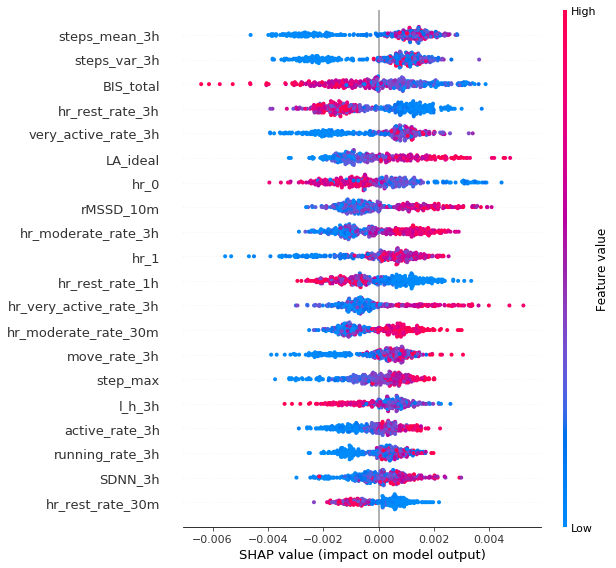

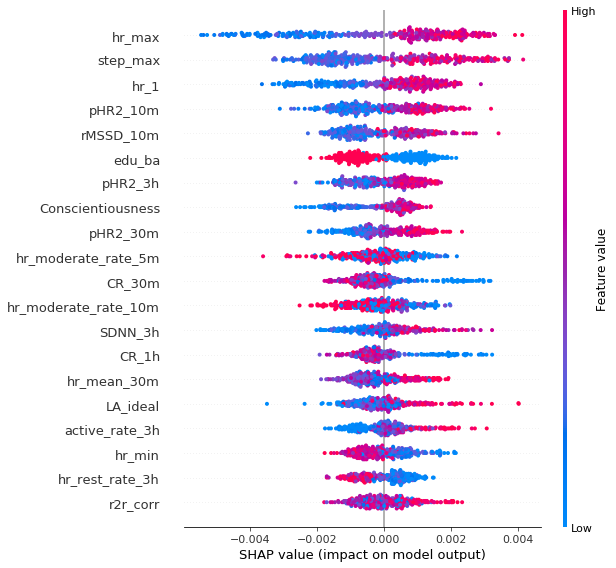

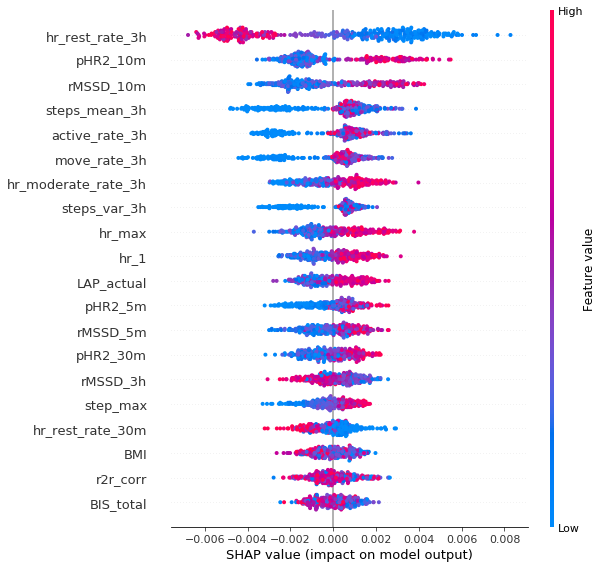

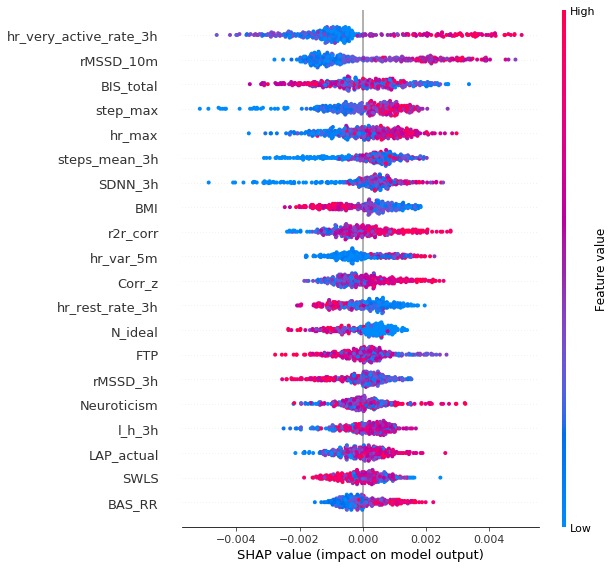

array(['cls', 'all', 'no', 'cur', '0', '0.566', '0.8772522522522522',
       '0.5899387393586931', '0.11437908496732026', '0.3757900757900758',
       '0.705207598553743', '0.0', '0.0'], dtype='<U32')

In [8]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import catboost
from evaluation_tools import eval_class, eval_reg, get_feature_imp_plot, convert_reg_to_class, catboost_feature_importance
from sklearn.model_selection import GroupKFold, StratifiedKFold
import pdb

# File for model
result = pd.DataFrame(columns=['model_id','problem_type', 'data_type', 'data_sample', 'user_type', 'param_index', 'accuracy', 'recall', 'precision', 'specificity', 'npv', 'f1', 'RMSE', 'r2'])
result.to_csv('model_relative_evaluation.csv', index=False)

fitbit_features = ['step_max', 'step_min', 'step_median', 'steps_max_3h',
    'steps_min_3h', 'steps_mean_3h', 'steps_var_3h', 'steps_median_3h',
    'move_rate_3h', 'active_rate_3h', 'very_active_rate_3h',
    'running_rate_3h', 'steps_max_1h', 'steps_min_1h', 'steps_mean_1h',
    'steps_var_1h', 'steps_median_1h', 'move_rate_1h',
    'active_rate_1h', 'very_active_rate_1h', 'running_rate_1h',
    'steps_max_30m', 'steps_min_30m', 'steps_mean_30m',
    'steps_var_30m', 'steps_median_30m', 'move_rate_30m',
    'active_rate_30m', 'very_active_rate_30m', 'running_rate_30m',
    'steps_max_10m', 'steps_min_10m', 'steps_mean_10m',
    'steps_var_10m', 'steps_median_10m', 'move_rate_10m',
    'active_rate_10m', 'very_active_rate_10m', 'running_rate_10m',
    'steps_max_5m', 'steps_min_5m', 'steps_mean_5m', 'steps_var_5m',
    'steps_median_5m', 'move_rate_5m', 'active_rate_5m',
    'very_active_rate_5m', 'running_rate_5m', 'hr_max', 'hr_min',
    'hr_med', 'hr_0', 'hr_0.3', 'hr_0.5', 'hr_0.8', 'hr_1', 'SDNN_3h',
    'pHR2_3h', 'rMSSD_3h', 'low_hr_3h', 'high_hr_3h', 'l_h_3h',
    'CR_3h', 'hr_mean_3h', 'hr_var_3h', 'hr_std_3h', 'hr_median_3h',
    'hr_rest_rate_3h', 'hr_moderate_rate_3h', 'hr_very_active_rate_3h',
    'SDNN_1h', 'pHR2_1h', 'rMSSD_1h', 'low_hr_1h', 'high_hr_1h',
    'l_h_1h', 'CR_1h', 'hr_mean_1h', 'hr_var_1h', 'hr_std_1h',
    'hr_median_1h', 'hr_rest_rate_1h', 'hr_moderate_rate_1h',
    'hr_very_active_rate_1h', 'SDNN_30m', 'pHR2_30m', 'rMSSD_30m',
    'low_hr_30m', 'high_hr_30m', 'l_h_30m', 'CR_30m', 'hr_mean_30m',
    'hr_var_30m', 'hr_std_30m', 'hr_median_30m', 'hr_rest_rate_30m',
    'hr_moderate_rate_30m', 'hr_very_active_rate_30m', 'SDNN_10m',
    'pHR2_10m', 'rMSSD_10m', 'low_hr_10m', 'high_hr_10m', 'l_h_10m',
    'CR_10m', 'hr_mean_10m', 'hr_var_10m', 'hr_std_10m',
    'hr_median_10m', 'hr_rest_rate_10m', 'hr_moderate_rate_10m',
    'hr_very_active_rate_10m', 'SDNN_5m', 'pHR2_5m', 'rMSSD_5m',
    'low_hr_5m', 'high_hr_5m', 'l_h_5m', 'CR_5m', 'hr_mean_5m',
    'hr_var_5m', 'hr_std_5m', 'hr_median_5m', 'hr_rest_rate_5m',
    'hr_moderate_rate_5m', 'hr_very_active_rate_5m']

all_features = fitbit_features + ['SBQ', 'FTP', 'SWLS', 'Neuroticism', 
    'Extraversion', 'Conscientiousness', 'NS_total', 'BIS_total', 
    'BIS.5', 'BAS_D', 'BAS_FS', 'BAS_RR', 'HAP_actual', 'P_actual', 
    'LAP_actual', 'LA_actual', 'LAN_actual', 'N_actual', 'HAN_actual', 
    'HA_actual', 'HAP_ideal', 'P_ideal', 'LAP_ideal', 'LA_ideal', 
    'LAN_ideal', 'N_ideal', 'HAN_ideal', 'HA_ideal', 'Children', 'Age', 
    'BMI', 'survey_hour', 'r2r_corr', 'Corr_z', 'edu_hs', 
    'edu_ba', 'edu_ma', 'edu_phd', 'is_married', 'is_divorced', 
    'is_single', 'is_widowed', 'is_with_partner', 'income']


# Existing Users
X_stratified_val = pd.read_csv('../data/processed/cur_user/X_val_stratify.csv')
y_stratified_val = pd.read_csv('../data/processed/cur_user/y_val_stratify.csv')
X_stratified_test = pd.read_csv('../data/processed/cur_user/X_test_stratify.csv')
y_stratified_test = pd.read_csv('../data/processed/cur_user/y_test_stratify.csv')
X_stratified_train = pd.read_csv('../data/processed/cur_user/X_train_stratify.csv')
y_stratified_train = pd.read_csv('../data/processed/cur_user/y_train_stratify.csv')
X_stratified_up_train = pd.read_csv('../data/processed/cur_user/X_train_stratify_up.csv')
y_stratified_up_train = pd.read_csv('../data/processed/cur_user/y_train_stratify_up.csv')


# New Users
X_group_val = pd.read_csv('../data/processed/new_user/X_val_group.csv')
y_group_val = pd.read_csv('../data/processed/new_user/y_val_group.csv')
X_group_test = pd.read_csv('../data/processed/new_user/X_test_group.csv')
y_group_test = pd.read_csv('../data/processed/new_user/y_test_group.csv')
X_group_train = pd.read_csv('../data/processed/new_user/X_train_group.csv')
y_group_train = pd.read_csv('../data/processed/new_user/y_train_group.csv')
X_group_up_train = pd.read_csv('../data/processed/new_user/X_train_group_up.csv')
y_group_up_train = pd.read_csv('../data/processed/new_user/y_train_group_up.csv')


param1 = {
    'verbose': 10,
    'random_seed': 24,
    'depth':10, 
    'learning_rate':0.001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}
params = [param1]


def upsample_data(X, y):
    # concatenate our training data back together
    data_to_sample = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    unhappy = data_to_sample[data_to_sample['valence_relative_bin']==1]
    happy = data_to_sample[data_to_sample['valence_relative_bin']==0]

    # upsample minority
    unhappy_upsampled = resample(unhappy,
                        replace=True, # sample with replacement
                        n_samples=len(happy), # match number in majority class
                        random_state=27) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([happy, unhappy_upsampled])

    # Split train and test
    y_upsample = upsampled['valence_relative_bin']
    X_upsample = upsampled.drop('valence_relative_bin', axis=1)

    return X_upsample, y_upsample


def data_process(data_sample, X_train, y_train, param):
    if data_sample == 'up':
        X_train, y_train = upsample_data(X_train, y_train)
    elif data_sample == 'weight':
        class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
        param['class_weights'] = list(class_weights)
    elif data_sample == 'smote':
        sm = SMOTE(random_state=27, k_neighbors = 10, sampling_strategy=1.0)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    elif data_sample == 'no':
        pass
    else:   
        raise ValueError('Invalid value for <data_sample>')
    return X_train, y_train, param


def main(problem_type, data_type, data_sample, user_type, param_index):
    param = params[param_index] # Hyper params
    results = []

    if user_type == 'new':
        X_train = X_group_train
        y_train = y_group_train
        X_test = X_group_test
        y_test = y_group_test
        X_val = X_group_val
        y_val = y_group_val
    elif user_type == 'cur':
        X_train = X_stratified_train
        y_train = y_stratified_train
        X_test = X_stratified_test
        y_test = y_stratified_test
        X_val = X_stratified_val
        y_val = y_stratified_val
    else:
        raise ValueError('Invalid value for <user_type>')

    if data_type == 'fitbit':
        X_train = X_train[fitbit_features]
        X_test = X_test[fitbit_features]
        X_val = X_val[fitbit_features]
    elif data_type == 'all':
        X_train = X_train[all_features]
        X_test = X_test[all_features]
        X_val = X_val[all_features]
    else:   
        raise ValueError('Invalid value for <data_type>')

    if problem_type == 'cls':
        param['loss_function'] = 'Logloss'
        param['eval_metric'] = 'F1'
        X = pd.concat([X_train, X_test])
        y = pd.concat([y_train, y_test])
        group = y['subject'].values
        # Split K Fold
        if user_type == 'new':
            kfold = GroupKFold(n_splits=4).split(X,y,group)
        elif user_type == 'cur':
            kfold = StratifiedKFold(n_splits=4, random_state=27, shuffle=True).split(X, group)
        # Training
        for train_index, test_index in kfold:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_train = y_train['valence_relative_bin']
            y_test = y_test['valence_relative_bin']
            # pdb.set_trace()
            # Data Sampling
            X_train, y_train, param = data_process(data_sample, X_train, y_train, param)
            # CatBoost
            cat = catboost.CatBoostClassifier(**param)
            cat.fit(X_train, y_train,
                     eval_set = (X_test, y_test),
                     use_best_model = True,
                     verbose = False)
            y_pred = cat.predict(X_val)
            # pdb.set_trace()
            cat_res = eval_class(y_val['valence_relative_bin'], y_pred)
            results.append(cat_res +[0,0])
            get_feature_imp_plot(cat, "ShapValues", X_train, y_train, X_test, y_test, [])
            # feature_col = X_val.columns.values
            # fi_score = catboost_feature_importance(cat, feature_col)
            # fi_score.to_csv()
    
    elif problem_type == 'reg':
        param.pop('class_weights', None)
        param['loss_function'] = 'RMSE'
        param['eval_metric'] = 'RMSE'
        X = pd.concat([X_train, X_test])
        y = pd.concat([y_train, y_test])
        group = y['subject'].values
        # Split K Fold
        if user_type == 'new':
            kfold = GroupKFold(n_splits=4).split(X,y,group)
        elif user_type == 'cur':
            kfold = StratifiedKFold(n_splits=4, random_state=27, shuffle=True).split(X, group)
        # Training
        for train_index, test_index in kfold:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # Two model, one for positive valence, one for negative valence
            y_p_train = y_train['valence_p']
            y_p_test = y_test['valence_p']
            y_n_train = y_train['valence_n']
            y_n_test = y_test['valence_n']
            # Regression problem no data sampling technique
            # CatBoost
            model_p = catboost.CatBoostRegressor(**param)
            model_p.fit(X_train, y_train['valence_p'],
                        eval_set = (X_test, y_test['valence_p']),
                        use_best_model = True,
                        verbose = False)
            p_regr = model_p.predict(X_val)

            model_n = catboost.CatBoostRegressor(**param)
            model_n.fit(X_train, y_train['valence_n'],
                        eval_set = (X_test, y_test['valence_n']),
                        use_best_model = True,
                        verbose = False)
            n_regr = model_n.predict(X_val)

            y_pred = n_regr - p_regr - y_val['valence_score_median']
            y_reg = y_val['valence_relative']
            # print(model_regr)
            y_pred_cls = [1 if x >= 0 else 0 for x in y_pred]
            y_reg_cls = y_val['valence_relative_bin']
            # pdb.set_trace()
            cat_res = eval_class(y_reg_cls, y_pred_cls)
            reg_eval = eval_reg(y_reg, y_pred)
            results.append(cat_res + reg_eval)

    results = np.mean(results, axis=0)
    training_params = [problem_type, data_type, data_sample, user_type, param_index]
    return np.append(training_params, results)

main('cls', 'all', 'no', 'cur', 0)